# Timeseries Cycle Predictions

The goal of this notebook is to show how regression models can be used to predict the next "cycle" within a timeseries dataset.
The data being used has been generated randomly, but you are free to modify the `generate_synthetic_data` function or incorporate your own data set.


In [481]:
import pandas as pd
import numpy as np
from datetime import timedelta

## Generate synthetic data

In [482]:
# Seed
np.random.seed(42)

def generate_synthetic_data(num_users=10000):
    user_ids = []
    start_dates = []
    end_dates = []
    
    # Generate random user IDs
    unique_user_ids = np.random.choice(range(100000, 999999), num_users, replace=False)
    # Generate random number of cycles for each user between 10 and 50
    cycles_per_user = np.random.randint(10, 50, num_users)
    start_date = pd.to_datetime('2023-01-01')
    
    for idx, user in enumerate(unique_user_ids):
        cycle_start = start_date + timedelta(days=np.random.randint(7, 30))
        for cycle in range(cycles_per_user[idx]):
            # Generate a random start date for the first cycle and then subsequent cycles
            if cycle != 0:
                cycle_start += timedelta(days=np.random.randint(21, 35))  # Random gap between cycles

            # Generate end date based on start date and random cycle length (let's say between 4 to 21 days)
            cycle_end = cycle_start + timedelta(days=np.random.randint(4, 21))
            
            user_ids.append(user)
            start_dates.append(cycle_start)
            end_dates.append(cycle_end)
            
    return pd.DataFrame({
        'USER_ID': user_ids,
        'START_TIME': start_dates,
        'END_TIME': end_dates
    })


In [483]:
df = generate_synthetic_data()
df.head()

,USER_ID,START_TIME,END_TIME
0,924197,2023-01-25,2023-02-04
1,924197,2023-02-16,2023-02-26
2,924197,2023-03-14,2023-03-25
3,924197,2023-04-15,2023-04-30
4,924197,2023-05-07,2023-05-20


In [484]:
df['USER_ID'].nunique()

10000

In [485]:
# Add day delta between start_time and end_time
df['DURATION_DAYS'] = (df['END_TIME'] - df['START_TIME']).dt.days

In [486]:
df.head()

,USER_ID,START_TIME,END_TIME,DURATION_DAYS
0,924197,2023-01-25,2023-02-04,10
1,924197,2023-02-16,2023-02-26,10
2,924197,2023-03-14,2023-03-25,11
3,924197,2023-04-15,2023-04-30,15
4,924197,2023-05-07,2023-05-20,13


## Exploratory Data Analysis

In [487]:
import seaborn as sns

In [488]:
df['DURATION_DAYS'].value_counts()

DURATION_DAYS
17    17480
9     17437
14    17391
5     17390
7     17324
15    17308
10    17248
4     17203
19    17183
16    17153
12    17147
11    17139
8     17130
6     17112
13    17109
18    17077
20    16935
Name: count, dtype: int64

<Axes: xlabel='DURATION_DAYS', ylabel='Count'>

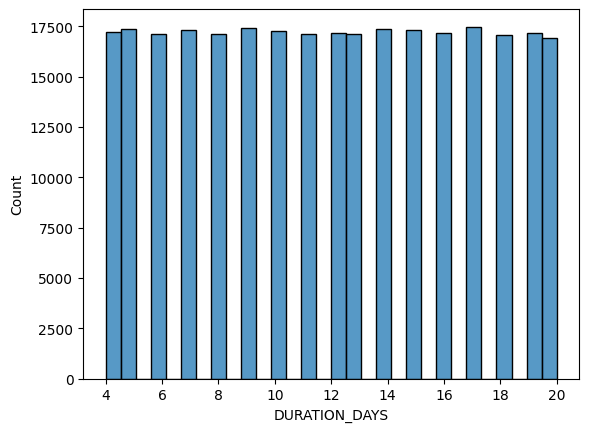

In [489]:
sns.histplot(df['DURATION_DAYS'], kde=False, bins=30)

In [490]:
df[['DURATION_DAYS']].describe()

,DURATION_DAYS
count,292766.000000
mean,11.989541
std,4.894605
min,4.000000
25%,8.000000
50%,12.000000
75%,16.000000
max,20.000000


## Feature Engineering
In this section, I am adding a simple feature for "day of week", such as weekend or weekday. 

In [491]:
df['START_TIME_DAY_TYPE'] = df['START_TIME'].dt.dayofweek.apply(lambda x: 0 if x < 5 else 1)
df['END_TIME_DAY_TYPE'] = df['END_TIME'].dt.dayofweek.apply(lambda x: 0 if x < 5 else 1)

df['PREV_CYCLE_END_TIME'] = df.groupby('USER_ID')['END_TIME'].shift(1)
df['DAYS_SINCE_LAST_CYCLE'] = abs(df['PREV_CYCLE_END_TIME'] - df['START_TIME']).dt.days
df['GAP_TO_NEXT'] = df['DAYS_SINCE_LAST_CYCLE'].shift(-1)

df.head()

,USER_ID,START_TIME,END_TIME,DURATION_DAYS,START_TIME_DAY_TYPE,END_TIME_DAY_TYPE,PREV_CYCLE_END_TIME,DAYS_SINCE_LAST_CYCLE,GAP_TO_NEXT
0,924197,2023-01-25,2023-02-04,10,0,1,NaT,NaN,12.0
1,924197,2023-02-16,2023-02-26,10,0,1,2023-02-04,12.0,16.0
2,924197,2023-03-14,2023-03-25,11,0,1,2023-02-26,16.0,21.0
3,924197,2023-04-15,2023-04-30,15,1,1,2023-03-25,21.0,7.0
4,924197,2023-05-07,2023-05-20,13,1,1,2023-04-30,7.0,19.0


<Axes: xlabel='DAYS_SINCE_LAST_CYCLE', ylabel='Count'>

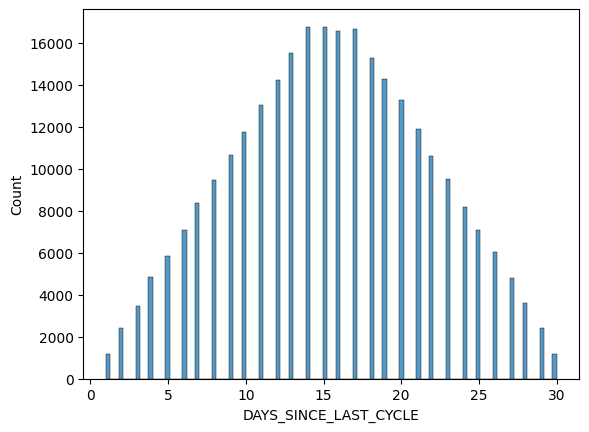

In [492]:
sns.histplot(data=df, x=df['DAYS_SINCE_LAST_CYCLE'], kde=False)

## Predict next cycle start date

In [493]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

### Make it production-ready

In [494]:
import pickle

def create_and_save_model(df, filename="model/model_cycle_prediction.pk"):
    # Remove rows with NaN values in the target column
    df.dropna(subset=['GAP_TO_NEXT', 'DAYS_SINCE_LAST_CYCLE', 'PREV_CYCLE_END_TIME'], inplace=True)

    # Features and target
    X = df[['DURATION_DAYS', 'START_TIME_DAY_TYPE', 'END_TIME_DAY_TYPE', 'DAYS_SINCE_LAST_CYCLE']]
    y = df['GAP_TO_NEXT']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train model
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate error
    error = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error in predicting gap to next cycle start: {error} days, or {int(error)} days rounded")

    # Pickle the trained model
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

    return filename


In [495]:
def predict_next_cycle_start(user_id, model_path, df):
    # Load the pickled model
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Extract the most recent cycle data for the user
    user_data = df[df['USER_ID'] == user_id]
    most_recent_data = user_data.iloc[-1]

    # Prepare this data in the same format as used for training
    X_single = most_recent_data[['DURATION_DAYS', 'START_TIME_DAY_TYPE', 'END_TIME_DAY_TYPE', 'DAYS_SINCE_LAST_CYCLE']]

    # Predict the gap to the next cycle start
    predicted_gap = model.predict([X_single])

    # Calculate the predicted start date for the next cycle
    predicted_start_date = pd.to_datetime(most_recent_data['END_TIME']) + pd.Timedelta(days=int(predicted_gap[0]))

    return predicted_start_date


## Test model

In [496]:
model_path = create_and_save_model(df)

Mean Absolute Error in predicting gap to next cycle start: 3.4903614351812156 days, or 3 days rounded


In [497]:
# Pick a user
random_user = df.sample()['USER_ID'].values[0]
random_user

219504

In [498]:
df[df['USER_ID'] == random_user]

,USER_ID,START_TIME,END_TIME,DURATION_DAYS,START_TIME_DAY_TYPE,END_TIME_DAY_TYPE,PREV_CYCLE_END_TIME,DAYS_SINCE_LAST_CYCLE,GAP_TO_NEXT
95415,219504,2023-02-19,2023-03-04,13,1,1,2023-02-02,17.0,15.0
95416,219504,2023-03-19,2023-04-07,19,1,0,2023-03-04,15.0,5.0
95417,219504,2023-04-12,2023-04-22,10,0,1,2023-04-07,5.0,11.0
95418,219504,2023-05-03,2023-05-15,12,0,0,2023-04-22,11.0,10.0
95419,219504,2023-05-25,2023-06-13,19,0,0,2023-05-15,10.0,7.0
95420,219504,2023-06-20,2023-06-29,9,0,0,2023-06-13,7.0,20.0
95421,219504,2023-07-19,2023-08-05,17,0,1,2023-06-29,20.0,17.0
95422,219504,2023-08-22,2023-09-01,10,0,0,2023-08-05,17.0,15.0
95423,219504,2023-09-16,2023-09-22,6,1,0,2023-09-01,15.0,17.0
95424,219504,2023-10-09,2023-10-15,6,0,1,2023-09-22,17.0,16.0


In [499]:
df[df['USER_ID'] == random_user].iloc[-1]

USER_ID                               219504
START_TIME               2024-11-19 00:00:00
END_TIME                 2024-11-27 00:00:00
DURATION_DAYS                              8
START_TIME_DAY_TYPE                        0
END_TIME_DAY_TYPE                          0
PREV_CYCLE_END_TIME      2024-10-26 00:00:00
DAYS_SINCE_LAST_CYCLE                   24.0
GAP_TO_NEXT                             16.0
Name: 95439, dtype: object

In [500]:
user_id = random_user  # Replace with the desired user's ID
predicted_date = predict_next_cycle_start(user_id, model_path, df)
print(f"Predicted start date of the next cycle for user {user_id}: {predicted_date.date()}")

Predicted start date of the next cycle for user 219504: 2024-12-16


/Users/alexanderbrunner/Desktop/Projects/menstrual-cycles/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [501]:
# Save dataframe
df.to_csv('data/users.csv', encoding='utf-8', index=False)